In [1]:
import numpy as np

#constant 
#r_0 = 387.4 #https://www.wolframalpha.com/input/?i=161.9+atomic+mass+unit+*+mu_0+*+%289.93+bohr+magneton%29%5E2+%2F+%284+pi+hbar%5E2%29+in+bohr+radius 
r_0 = 387.672168 
mu_m = 1.E-06 / (r_0 * 0.529E-10)

#input parameters


a_11 = 70 / r_0
a_22 = 70 / r_0
#a_12 =604.5 / r_0 #variable
a_12 = 69. / r_0 #variable


In [2]:

g_11 = 4*np.pi*a_11
g_22 = 4*np.pi*a_22
g_12 = 4*np.pi*a_12 #mass is the same
c_lhy = 8/(15*np.sqrt(2*np.pi * (4*np.pi)**3))

n_max = 0.3
n_grid_densities = 64
n_grid_theta = 4000

n_a = np.linspace(0, n_max, num = n_grid_densities)
n_b = n_a
n1, n2 = np.meshgrid(n_a, n_b, indexing='ij')

theta = np.linspace(0., np.pi, num = n_grid_theta)
sin_theta = np.sin(theta)  + 0.j
eta_11 = g_11 + 4*np.pi/3 * (3 * np.cos(theta)**2 - 1) + 0.j
eta_22 = g_22 + 4*np.pi/3 * (3 * np.cos(theta)**2 - 1) + 0.j
eta_12 = g_12 + 4*np.pi/3 * (3 * np.cos(theta)**2 - 1) + 0.j

def V_lambda(den1, den2):
    v1 = eta_11 * den1 + eta_22 * den2
    v2 = np.sqrt((eta_11*den1 - eta_22*den2)**2 + 4*eta_12**2 * den1*den2)
    return (v1 + v2) + 0.j , (v1 - v2) + 0.j

def lhy(den1, den2):
    dt = theta[1] - theta[0]
    v1, v2 = V_lambda(den1, den2)
    return c_lhy * np.sum(dt * sin_theta * (v1**2.5 + v2**2.5)  )

def get_lhy(n1, n2):
    en_out = np.copy(n1) + 0.j
    for i in range(n_grid_densities):
        for j in range(n_grid_densities):
            en_out[i,j] = lhy(n1[i,j], n2[i,j])
    return en_out.real

def d_V_lambda(den1, den2):
    d1, d2, d3, d4 = eta_11 + 0.j, eta_11 + 0.j, eta_22 + 0.j, eta_22 + 0.j
    
    d1_help  = (eta_11 * den1 - eta_22 * den2) * eta_11 + 2*eta_12**2 * den2 
    d1_help /= np.sqrt((eta_11 * den1 - eta_22 * den2)**2 + 4*eta_12**2 * den1 * den2)

    d2_help  = -(eta_11 * den1 - eta_22 * den2) * eta_22 + 2*eta_12**2 * den1
    d2_help /= np.sqrt((eta_11 * den1 - eta_22 * den2)**2 + 4*eta_12**2 * den1 * den2)

    d1 += d1_help
    d2 -= d1_help
    d3 += d2_help
    d4 -= d2_help
    
    return d1, d2, d3, d4

def mu_lhy(den1, den2):
    dt = theta[1] - theta[0]
    v1, v2 = V_lambda(den1, den2)
    d1, d2, d3, d4 = d_V_lambda(den1, den2)

    mu_a = c_lhy * dt * np.sum( 2.5 * (v1**1.5*d1 + v2**1.5*d2) * sin_theta)
    mu_b = c_lhy * dt * np.sum( 2.5 * (v1**1.5*d3 + v2**1.5*d4) * sin_theta)
    return mu_a.real, mu_b.real

def get_mu_lhy(n1, n2):
    mu_a = np.copy(n1)
    mu_b = np.copy(n1)
    for i in range(n_grid_densities):
        for j in range(n_grid_densities):
            mu_a[i,j], mu_b[i,j] = mu_lhy(n1[i,j], n2[i,j])
    return mu_a, mu_b

en_lhy = np.nan_to_num(get_lhy(n1, n2), posinf=0)
mu_a, mu_b = np.nan_to_num(get_mu_lhy(n1, n2), posinf=0)
print(np.shape(en_lhy))


<ipython-input-2-fb074f087cb7>:41: RuntimeWarning: invalid value encountered in true_divide
  d1_help /= np.sqrt((eta_11 * den1 - eta_22 * den2)**2 + 4*eta_12**2 * den1 * den2)
<ipython-input-2-fb074f087cb7>:44: RuntimeWarning: invalid value encountered in true_divide
  d2_help /= np.sqrt((eta_11 * den1 - eta_22 * den2)**2 + 4*eta_12**2 * den1 * den2)
(64, 64)


In [3]:
from scipy import interpolate
#lhy_interpolation = interpolate.interp2d(n1.ravel(), n2.ravel(), en_lhy.ravel(), kind='cubic')
lhy_interpolation = interpolate.RectBivariateSpline(n_a, n_b, en_lhy)

'''
dn= 0.0001
mu_a = (lhy_interpolation(n1 + dn, n2     , grid=False) - lhy_interpolation(n1, n2, grid=False)) / dn 
mu_b = (lhy_interpolation(n1,      n2 + dn, grid=False) - lhy_interpolation(n1, n2, grid=False)) / dn 
'''
mu_a_interpolation = interpolate.RectBivariateSpline(n_a, n_b, mu_a)
mu_b_interpolation = interpolate.RectBivariateSpline(n_a, n_b, mu_b)

print("interpolation finished")

import pickle
with open('interpolator_lhy_energy.pkl', 'wb') as f:
    pickle.dump(lhy_interpolation, f)
with open('interpolator_mu_a.pkl', 'wb') as f:
    pickle.dump(mu_a_interpolation, f)
with open('interpolator_mu_b.pkl', 'wb') as f:
    pickle.dump(mu_b_interpolation, f)  


interpolation finished


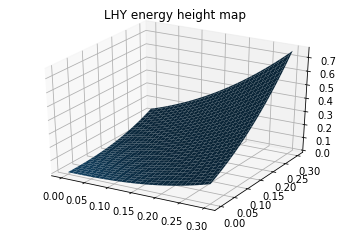

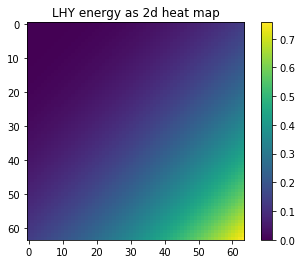

In [4]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import numpy as np

# show hight map in 3d
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(n1, n2, en_lhy)
plt.title('LHY energy height map')
plt.show()

# show hight map in 2d
plt.figure()
plt.title('LHY energy as 2d heat map')
p = plt.imshow(en_lhy)
plt.colorbar(p)
plt.show()

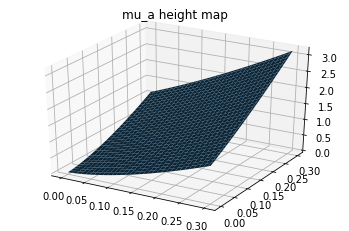

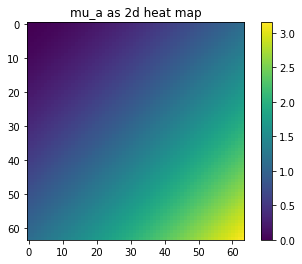

In [5]:
# show hight map in 3d
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(n1, n2, mu_a)
plt.title('mu_a height map')
plt.show()

# show hight map in 2d
plt.figure()
plt.title('mu_a as 2d heat map')
p = plt.imshow(mu_a)
plt.colorbar(p)
plt.show()

In [6]:
#print(en_lhy(0.1, 0.2))
print(lhy_interpolation(0.1, 0.1), lhy_interpolation([0.1, 0.2], [0.2, 0.3], grid=False))

#comparison with single-component
g=4*np.pi*a_11
edd = 1./3 / a_11
beta = 32*g*a_11**1.5 / (3*np.sqrt(np.pi)) * (1 + 1.5*edd**2) * 2./5
den = 0.1
print(beta*den**2.5, beta*den**2.5 / lhy_interpolation(den/2, den/2)  / 0.93841142)
print(beta*2.5*den**1.5, beta*2.5*den**1.5 / mu_a_interpolation(den/2, den/2) / 0.93665445 )

[[0.04855751]] [0.13389203 0.47995851]
0.00809996350534475 [[1.0055609]]
0.20249908763361874 [[1.00744717]]


In [7]:
#estimating the speed of execution
ngrid=64
x = np.linspace(0, 1, ngrid**3)
%timeit lhy_interpolation(x, x, grid=False)
x = np.random.uniform(0, 1, (ngrid, ngrid, ngrid) ) + np.random.uniform(0, 1, (ngrid, ngrid, ngrid) ) *1.j
%timeit np.fft.fftn(x)

123 ms ± 16.6 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
16.8 ms ± 611 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [8]:
#print(get_mu_lhy(n1, n2))